# Notebook for scraping UFC-stats pages

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 

Start url:


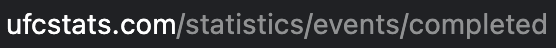

Second url:


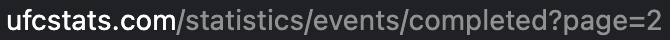

Last url:


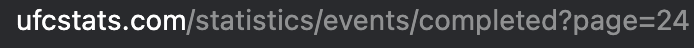

In [13]:
img_name_prefix = ["start", "second", "last"]

for prefix in img_name_prefix:
    print(f"{prefix} url:".capitalize())
    display(Image(filename=f"img/{prefix}_url.png"))

## As we can see above, pattern of ufc stats urls is clear:
 - First page has unique url suffix pattern:
      - Page &emsp;1: '.../completed'
 - The rest of urls have a clear suffix pattern: 
     - Page &emsp;2: '.../completed**?page=2**'
     - Page &emsp;3: '.../completed**?page=3**'
     - ...
     - Page &ensp;24: '.../completed**?page=24**'

In [14]:
sfx_ptrn = "?page="
suffixes = [''] # initially only 1 member - empty string, because of the unique start
suffixes += [sfx_ptrn + str(i) for i in range(2, 25)] # 
print(suffixes)

['', '?page=2', '?page=3', '?page=4', '?page=5', '?page=6', '?page=7', '?page=8', '?page=9', '?page=10', '?page=11', '?page=12', '?page=13', '?page=14', '?page=15', '?page=16', '?page=17', '?page=18', '?page=19', '?page=20', '?page=21', '?page=22', '?page=23', '?page=24']


In [16]:
import requests
url_start = "http://ufcstats.com/statistics/events/completed{}" # notice {} at the end

for i, sfx in enumerate(suffixes):
    print((f"pages/page_{i+1}")) # i starts from 0, but pages from 1
    url  = url_start.format(sfx)
    print(url)
    data = requests.get(url)
    with open(f"pages/page_{i+1}.html", "w+") as f:
        f.write(data.text)

pages/page_1
http://ufcstats.com/statistics/events/completed
pages/page_2
http://ufcstats.com/statistics/events/completed?page=2
pages/page_3
http://ufcstats.com/statistics/events/completed?page=3
pages/page_4
http://ufcstats.com/statistics/events/completed?page=4
pages/page_5
http://ufcstats.com/statistics/events/completed?page=5
pages/page_6
http://ufcstats.com/statistics/events/completed?page=6
pages/page_7
http://ufcstats.com/statistics/events/completed?page=7
pages/page_8
http://ufcstats.com/statistics/events/completed?page=8
pages/page_9
http://ufcstats.com/statistics/events/completed?page=9
pages/page_10
http://ufcstats.com/statistics/events/completed?page=10
pages/page_11
http://ufcstats.com/statistics/events/completed?page=11
pages/page_12
http://ufcstats.com/statistics/events/completed?page=12
pages/page_13
http://ufcstats.com/statistics/events/completed?page=13
pages/page_14
http://ufcstats.com/statistics/events/completed?page=14
pages/page_15
http://ufcstats.com/statistics/

## Let's extract all links of events

In [5]:
from bs4 import BeautifulSoup

In [87]:
def get_events_links(page_path):
    with open(page_path) as f:
        page = f.read()
    soup = BeautifulSoup(page, "html.parser")
    tags_with_events_links = soup.find_all('a', class_="b-link b-link_style_black");
    events_links = [i['href'] for i in tags_with_events_links]
    return events_links

In [88]:
import numpy as np

In [159]:
link_lists = [get_events_links(f"pages/page_{i}.html") for i in range(1,25)]

In [160]:
tbl_links = np.concatenate(link_lists, axis=0, dtype='object')

## We expect links to contain 24 * 25 - 1 links
- 24 - number of pages
- 25 - number of links per page
- 1 &nbsp; - upcoming event on October 10th

In [166]:
assert(24*25 - 1 == len(tbl_links))

## Now, let's get all tables and save them into separate .csv files for each page

In [125]:
import pandas as pd

In [ ]:
def file_exists(file_path):
    import os.path
    os.path.isfile(file_path)

def get_page_tables(page_num):
    pass
    
def table_to_csv(page_num):
    pass

In [230]:
tmp_df = pd.DataFrame()

for idx in range(len(link)):
    tmp_df = pd.concat([tmp_df, pd.read_html(link_lists[0][idx])[0]], axis=0)

In [233]:
tmp_df.iloc[0, :]

W/L                                     win
Fighter         Cory Sandhagen  Song Yadong
Kd                                     0  0
Str                                  94  54
Td                                     1  2
Sub                                    0  0
Weight class                   Bantamweight
Method                               KO/TKO
Round                                     4
Time                                   5:00
Name: 0, dtype: object

In [184]:
for page_num, link_list in enumerate(link_lists):
    print(f"{i}\t{len(link_list)}")
    get_page_tables(page_num+1)

0	24
1	25
2	25
3	25
4	25
5	25
6	25
7	25
8	25
9	25
10	25
11	25
12	25
13	25
14	25
15	25
16	25
17	25
18	25
19	25
20	25
21	25
22	25
23	25


In [183]:
tbl_links[0]

'http://ufcstats.com/event-details/8d477c3fbe001f9d'

In [172]:
df = pd.DataFrame()

for i, link in enumerate(tbl_links):
    if i == 2:
        break
    df = pd.concat([df, pd.read_html(link)[0]], axis=0)

In [173]:
df.shape

(26, 10)

In [174]:
df

,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time
0,win,Cory Sandhagen Song Yadong,0 0,94 54,1 2,0 0,Bantamweight,KO/TKO,4,5:00
1,win,Gregory Rodrigues Chidi Njokuani,1 0,48 44,1 0,0 0,Middleweight,KO/TKO Punches,2,1:27
2,win,Andre Fili Bill Algeo,0 0,59 81,1 0,2 0,Featherweight,S-DEC,3,5:00
3,win,Joe Pyfer Alen Amedovski,1 0,14 11,0 0,0 0,Middleweight,KO/TKO Punch,1,3:55
4,win,Rodrigo Nascimento Tanner Boser,0 0,36 62,3 0,1 0,Heavyweight,S-DEC,3,5:00
5,win,Anthony Hernandez Marc-Andre Barriault,0 0,39 25,8 0,2 0,Middleweight,SUB Arm Triangle,3,1:53
6,win,Damon Jackson Pat Sabatini,0 0,11 1,1 0,0 0,Featherweight,KO/TKO Punches,1,1:09
7,win,Trevin Giles Louis Cosce,0 0,25 10,2 1,0 1,Welterweight,U-DEC,3,5:00
8,win,Loma Lookboonmee Denise Gomes,0 0,48 19,4 0,0 3,Women's Strawweight,U-DEC,3,5:00
9,win,Trey Ogden Daniel Zellhuber,0 0,71 52,1 0,0 0,Lightweight,U-DEC,3,5:00
